In [ ]:
# Cell 1 - Imports & configuration
import os
import time
import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    accuracy_score,
)

# Classical + Tree
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# External Boosters
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import VotingClassifier, StackingClassifier

sns.set_style("whitegrid")

BASE_DIR = r"D:\ML_Project"
DATA_PATH = os.path.join(
    BASE_DIR, "data", "processed", "PROJECT_CLUSTERED_SEVERITY_DATA.csv"
)
MODELS_DIR = os.path.join(BASE_DIR, "models")
RESULTS_DIR = os.path.join(BASE_DIR, "results")

os.makedirs(MODELS_DIR, exist_ok=True)
os.makedirs(RESULTS_DIR, exist_ok=True)

RANDOM_STATE = 42
CV_FOLDS = 5
N_JOBS = 4  # safe moderate load
FORCE_USE_GPU = True

print("CONFIG → CV_FOLDS:", CV_FOLDS, "| N_JOBS:", N_JOBS)

CONFIG → CV_FOLDS: 5 | N_JOBS: 4


In [ ]:
# Cell 2 - Load and preprocess
df = pd.read_csv(DATA_PATH, low_memory=False)
print("Loaded rows:", len(df))

# Mapping clusters → phenotype names
cluster_to_pheno = {
    "Cluster_0": "Critical_Failure",
    "Cluster_1": "Hospitalization_Failure",
    "Cluster_2": "SideEffect_Failure",
}

df["failure_phenotype_label"] = df["failure_phenotype_label"].replace(cluster_to_pheno)

drop_cols = [
    "primaryid",
    "caseid",
    "caseversion",
    "fda_dt_parsed",
    "all_reaction_pts",
    "severity_category",
    "severity_weight",
    "failure_phenotype",
    "is_failure",
]
df = df.drop(columns=[c for c in drop_cols if c in df.columns], errors="ignore")

X = df.drop(columns=["failure_phenotype_label"])
y = df["failure_phenotype_label"]

print("\nClass distribution:\n", y.value_counts())

# Encode labels
le = LabelEncoder()
y_enc = le.fit_transform(y)
joblib.dump(le, os.path.join(MODELS_DIR, "label_encoder.joblib"))

# Scale numeric columns
num_cols = [c for c in X.columns if np.issubdtype(X[c].dtype, np.number)]
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])
joblib.dump(scaler, os.path.join(MODELS_DIR, "scaler.joblib"))

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y_enc, test_size=0.2, stratify=y_enc, random_state=RANDOM_STATE
)

print("Train:", X_train.shape, "| Test:", X_test.shape)

Loaded rows: 249048

Class distribution:
 failure_phenotype_label
Critical_Failure           211621
SideEffect_Failure          19777
Hospitalization_Failure     17650
Name: count, dtype: int64
Train: (199238, 20) | Test: (49810, 20)


In [ ]:
# Cell 3 — Fast model grids

n_classes = len(le.classes_)

param_grids = {
    "Logistic Regression": {
        "C": [0.5, 1, 2, 5],
        "solver": ["lbfgs"],
        "class_weight": ["balanced"],
    },
    "SVC (linear)": {"C": [0.5, 1, 2, 5]},
    # "SVC (rbf)": {
    #     "C": [0.5, 1, 2],
    #     "gamma": ["scale", "auto"]
    # },
    "Decision Tree": {"max_depth": [None, 10, 20], "min_samples_split": [2, 5]},
    "Random Forest": {
        "n_estimators": [200, 300],
        "max_depth": [None, 20],
        "min_samples_split": [2, 5],
        "class_weight": ["balanced"],
    },
    "Gradient Boosting": {"n_estimators": [150, 250], "learning_rate": [0.05, 0.1]},
    "XGBoost": {
        "n_estimators": [200, 300],
        "max_depth": [4, 6],
        "learning_rate": [0.1],
    },
    "LightGBM": {"n_estimators": [200, 300], "learning_rate": [0.05, 0.1]},
}

models = {
    "Logistic Regression": LogisticRegression(max_iter=5000),
    "SVC (linear)": LinearSVC(random_state=RANDOM_STATE),
    # "SVC (rbf)": SVC(kernel="rbf"),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
    "XGBoost": XGBClassifier(
        objective="multi:softprob",
        num_class=n_classes,
        device="cuda",  # Enable GPU
        tree_method="hist" if FORCE_USE_GPU else "auto",
        predictor="gpu_predictor" if FORCE_USE_GPU else "cpu_predictor",
    ),
    "LightGBM": LGBMClassifier(
        objective="multiclass",
        num_class=n_classes,
        device="gpu" if FORCE_USE_GPU else "cpu",
    ),
}

print("Models ready:", list(models.keys()))

Models ready: ['Logistic Regression', 'SVC (linear)', 'Decision Tree', 'Random Forest', 'Gradient Boosting', 'XGBoost', 'LightGBM']


In [ ]:
# Cell 4 — Grid Search
best_models = {}
best_scores = {}
grid_timings = {}

skf = StratifiedKFold(n_splits=CV_FOLDS, shuffle=True, random_state=RANDOM_STATE)

for name, model in models.items():
    print("\n" + "=" * 80)
    print(f"GRID SEARCH → {name}")

    gs = GridSearchCV(
        model,
        param_grids[name],
        scoring="f1_macro",
        cv=skf,
        n_jobs=N_JOBS,
        verbose=1,
        refit=True,
    )

    t0 = time.time()
    gs.fit(X_train, y_train)
    t1 = time.time()

    best_models[name] = gs.best_estimator_
    best_scores[name] = gs.best_score_
    grid_timings[name] = t1 - t0

    print(f"Best CV F1 = {gs.best_score_:.4f} | Time = {grid_timings[name]:.1f}s")
    print("Best Params:", gs.best_params_)

    joblib.dump(
        gs.best_estimator_, os.path.join(MODELS_DIR, f"grid_best_{name}.joblib")
    )


GRID SEARCH → Logistic Regression
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best CV F1 = 0.7644 | Time = 13.7s
Best Params: {'C': 5, 'class_weight': 'balanced', 'solver': 'lbfgs'}

GRID SEARCH → SVC (linear)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best CV F1 = 0.6644 | Time = 9.1s
Best Params: {'C': 5}

GRID SEARCH → Decision Tree
Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best CV F1 = 0.7775 | Time = 2.1s
Best Params: {'max_depth': 20, 'min_samples_split': 5}

GRID SEARCH → Random Forest
Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best CV F1 = 0.8091 | Time = 173.1s
Best Params: {'class_weight': 'balanced', 'max_depth': 20, 'min_samples_split': 5, 'n_estimators': 300}

GRID SEARCH → Gradient Boosting
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Best CV F1 = 0.7735 | Time = 338.5s
Best Params: {'learning_rate': 0.1, 'n_estimators': 250}

GRID SEARCH → XGBoost
Fitting 5 folds for each of 4 candidates,

d:\ML_Project\ml_env\Lib\site-packages\xgboost\training.py:199: UserWarning: [17:28:35] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:790: 
Parameters: { "predictor" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Best CV F1 = 0.7828 | Time = 32.9s
Best Params: {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 300}

GRID SEARCH → LightGBM
Fitting 5 folds for each of 4 candidates, totalling 20 fits


d:\ML_Project\ml_env\Lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 374
[LightGBM] [Info] Number of data points in the train set: 199238, number of used features: 20
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 5070 Ti Laptop GPU, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 256 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Info] Size of histogram bin entry: 8
[LightGBM] [Info] 7 dense feature groups (1.52 MB) transferred to GPU in 0.001570 secs. 1 sparse feature groups
[LightGBM] [Info] Start training from score -0.162851
[LightGBM] [Info] Start training from score -2.646908
[LightGBM] [Info] Start training from score -2.533099
Best CV F1 = 0.7864 | Time = 70.5s
Best Params: {'learning_rate': 0.1, 'n_estimators': 300}



=== EVALUATION ON TEST SET (with PR-AUC) ===

--------------------------------------------------------------------------------
MODEL: Logistic Regression
Test F1: 0.7671 | Accuracy: 0.8205
Macro PR-AUC: 0.8100

Per-class PR-AUC:
  Critical_Failure: 0.9920
  Hospitalization_Failure: 0.9398
  SideEffect_Failure: 0.4983

Classification Report
                         precision    recall  f1-score   support

       Critical_Failure       0.99      0.79      0.88     42325
Hospitalization_Failure       0.92      0.98      0.95      3530
     SideEffect_Failure       0.31      0.96      0.47      3955

               accuracy                           0.82     49810
              macro avg       0.74      0.91      0.77     49810
           weighted avg       0.93      0.82      0.85     49810



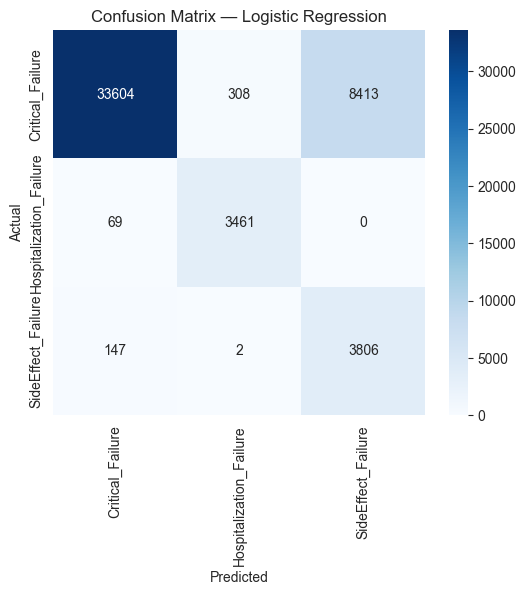

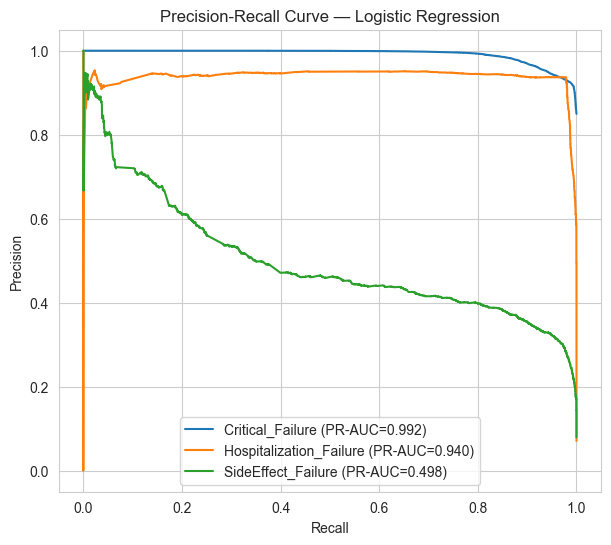


--------------------------------------------------------------------------------
MODEL: SVC (linear)
Model has no predict_proba — using decision_function
Test F1: 0.6680 | Accuracy: 0.9173
Macro PR-AUC: 0.8151

Per-class PR-AUC:
  Critical_Failure: 0.9917
  Hospitalization_Failure: 0.9529
  SideEffect_Failure: 0.5007

Classification Report
                         precision    recall  f1-score   support

       Critical_Failure       0.92      0.99      0.95     42325
Hospitalization_Failure       0.94      0.98      0.96      3530
     SideEffect_Failure       0.79      0.05      0.09      3955

               accuracy                           0.92     49810
              macro avg       0.88      0.67      0.67     49810
           weighted avg       0.91      0.92      0.89     49810



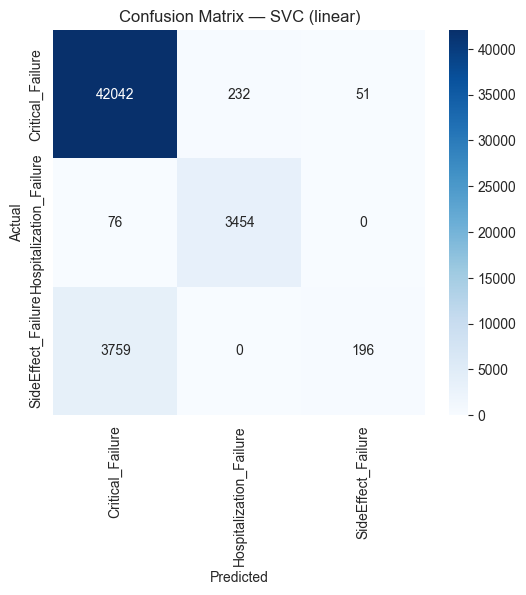

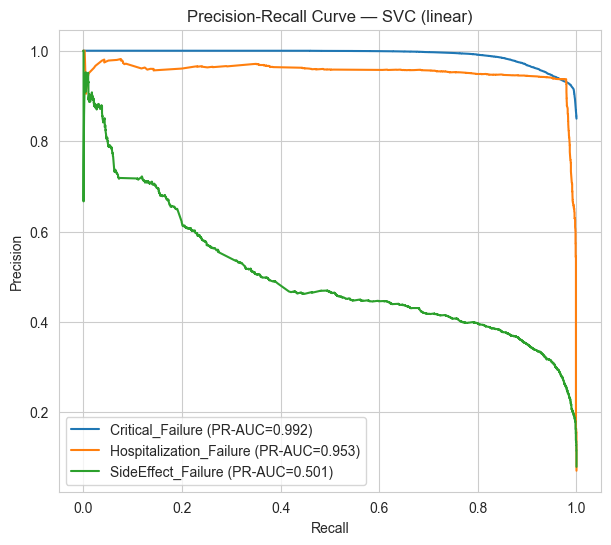


--------------------------------------------------------------------------------
MODEL: Decision Tree
Test F1: 0.7823 | Accuracy: 0.9179
Macro PR-AUC: 0.7801

Per-class PR-AUC:
  Critical_Failure: 0.9796
  Hospitalization_Failure: 0.9133
  SideEffect_Failure: 0.4475

Classification Report
                         precision    recall  f1-score   support

       Critical_Failure       0.94      0.96      0.95     42325
Hospitalization_Failure       0.93      0.95      0.94      3530
     SideEffect_Failure       0.55      0.38      0.45      3955

               accuracy                           0.92     49810
              macro avg       0.81      0.77      0.78     49810
           weighted avg       0.91      0.92      0.91     49810



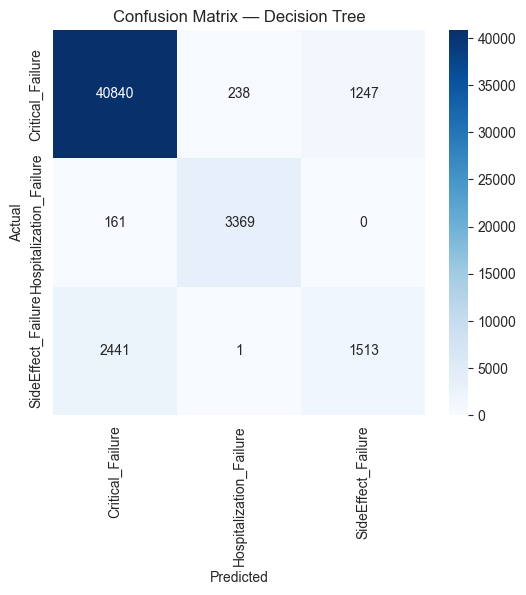

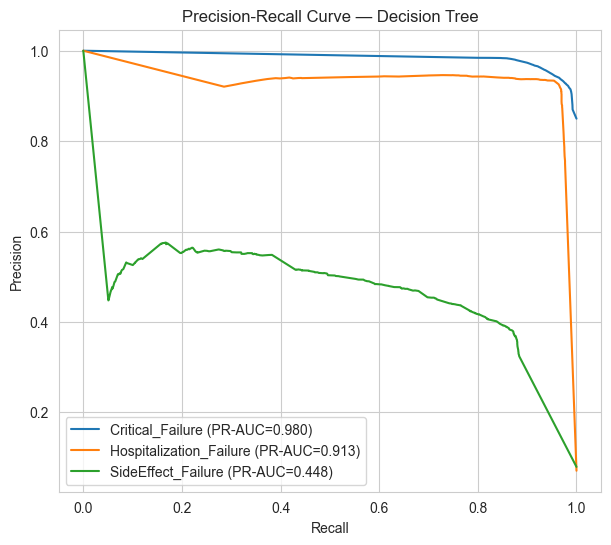


--------------------------------------------------------------------------------
MODEL: Random Forest
Test F1: 0.8102 | Accuracy: 0.8807
Macro PR-AUC: 0.8384

Per-class PR-AUC:
  Critical_Failure: 0.9925
  Hospitalization_Failure: 0.9566
  SideEffect_Failure: 0.5661

Classification Report
                         precision    recall  f1-score   support

       Critical_Failure       0.98      0.87      0.93     42325
Hospitalization_Failure       0.93      0.98      0.95      3530
     SideEffect_Failure       0.40      0.87      0.55      3955

               accuracy                           0.88     49810
              macro avg       0.77      0.91      0.81     49810
           weighted avg       0.93      0.88      0.90     49810



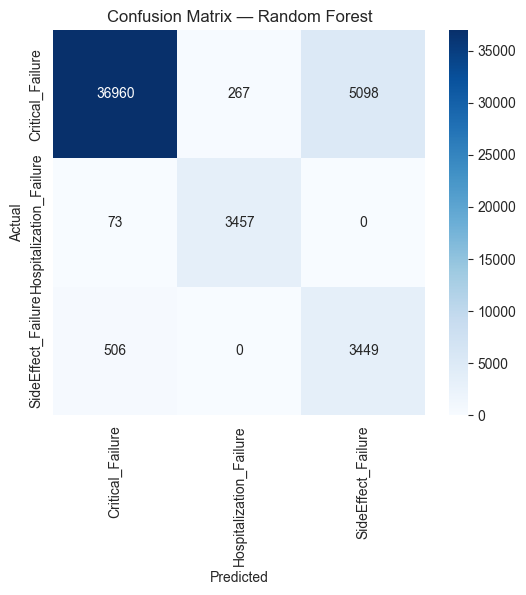

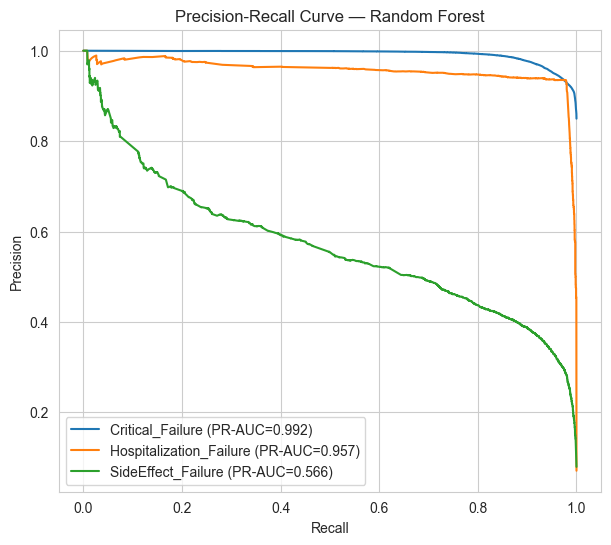


--------------------------------------------------------------------------------
MODEL: Gradient Boosting
Test F1: 0.7739 | Accuracy: 0.9229
Macro PR-AUC: 0.8367

Per-class PR-AUC:
  Critical_Failure: 0.9932
  Hospitalization_Failure: 0.9613
  SideEffect_Failure: 0.5557

Classification Report
                         precision    recall  f1-score   support

       Critical_Failure       0.94      0.98      0.96     42325
Hospitalization_Failure       0.94      0.98      0.96      3530
     SideEffect_Failure       0.60      0.31      0.41      3955

               accuracy                           0.92     49810
              macro avg       0.83      0.75      0.77     49810
           weighted avg       0.91      0.92      0.91     49810



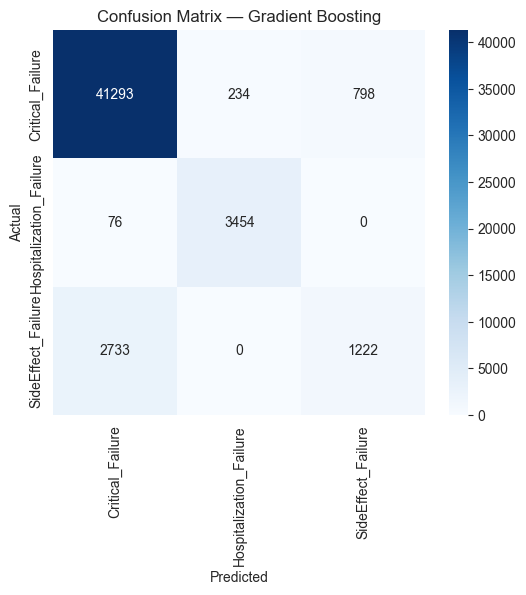

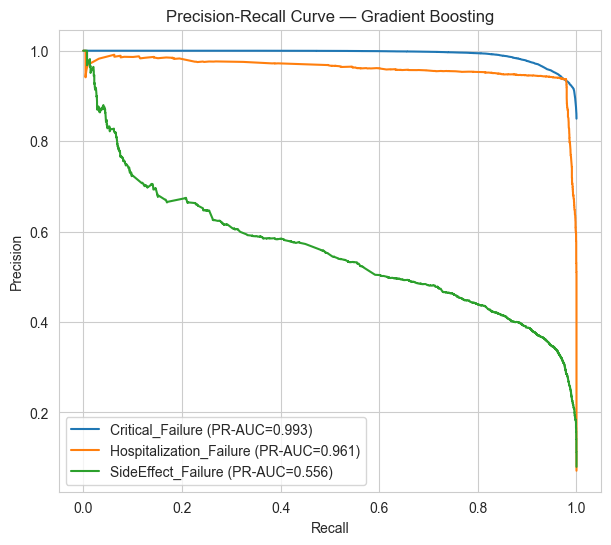


--------------------------------------------------------------------------------
MODEL: XGBoost
Test F1: 0.7852 | Accuracy: 0.9253
Macro PR-AUC: 0.8412

Per-class PR-AUC:
  Critical_Failure: 0.9935
  Hospitalization_Failure: 0.9595
  SideEffect_Failure: 0.5707

Classification Report
                         precision    recall  f1-score   support

       Critical_Failure       0.94      0.98      0.96     42325
Hospitalization_Failure       0.94      0.98      0.96      3530
     SideEffect_Failure       0.63      0.34      0.44      3955

               accuracy                           0.93     49810
              macro avg       0.83      0.76      0.79     49810
           weighted avg       0.91      0.93      0.92     49810



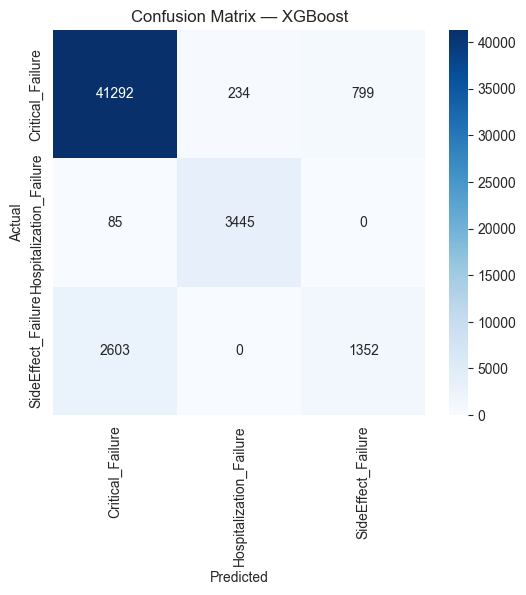

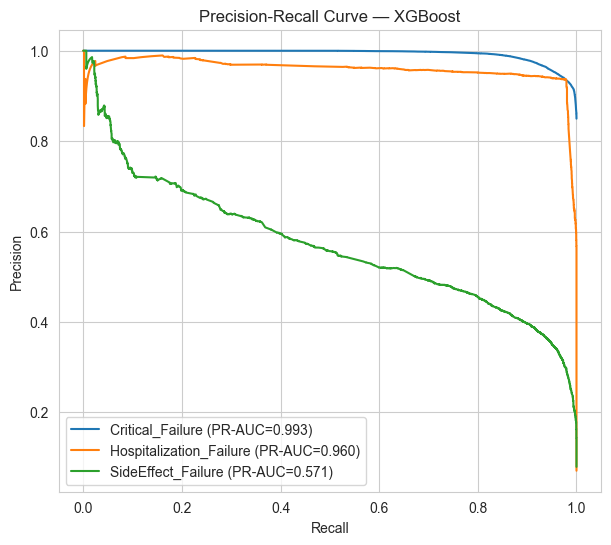


--------------------------------------------------------------------------------
MODEL: LightGBM
Test F1: 0.7858 | Accuracy: 0.9242
Macro PR-AUC: 0.8416

Per-class PR-AUC:
  Critical_Failure: 0.9934
  Hospitalization_Failure: 0.9593
  SideEffect_Failure: 0.5722

Classification Report
                         precision    recall  f1-score   support

       Critical_Failure       0.94      0.97      0.96     42325
Hospitalization_Failure       0.94      0.97      0.95      3530
     SideEffect_Failure       0.61      0.35      0.45      3955

               accuracy                           0.92     49810
              macro avg       0.83      0.77      0.79     49810
           weighted avg       0.91      0.92      0.92     49810



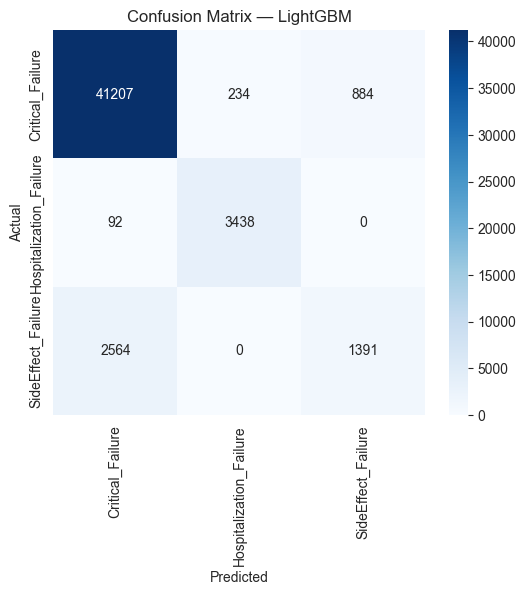

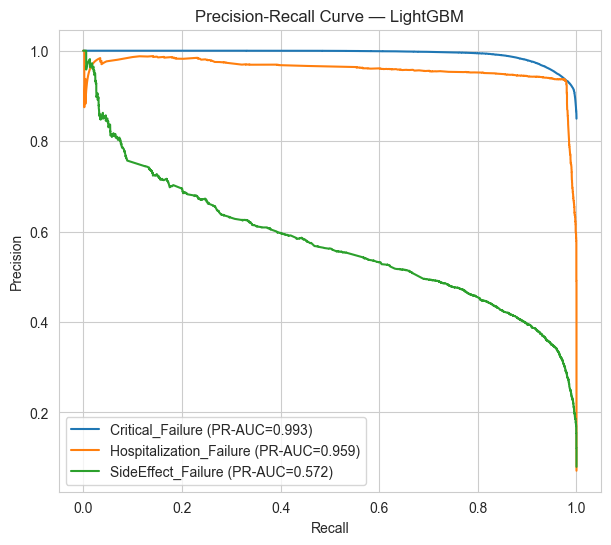

,Model,F1,Accuracy,Macro PR-AUC,Per-Class PR-AUC
3,Random Forest,0.810152,0.880667,0.838398,"{'Critical_Failure': 0.992486215300992, 'Hospi..."
6,LightGBM,0.785832,0.924232,0.841625,"{'Critical_Failure': 0.9933959518526873, 'Hosp..."
5,XGBoost,0.785159,0.925296,0.841222,"{'Critical_Failure': 0.9934682892821289, 'Hosp..."
2,Decision Tree,0.782314,0.917928,0.780134,"{'Critical_Failure': 0.9796043361159676, 'Hosp..."
4,Gradient Boosting,0.773882,0.922887,0.836711,"{'Critical_Failure': 0.9931968465334566, 'Hosp..."
0,Logistic Regression,0.767118,0.820538,0.810010,"{'Critical_Failure': 0.9919985301410787, 'Hosp..."
1,SVC (linear),0.667973,0.917326,0.815124,"{'Critical_Failure': 0.991721216183958, 'Hospi..."


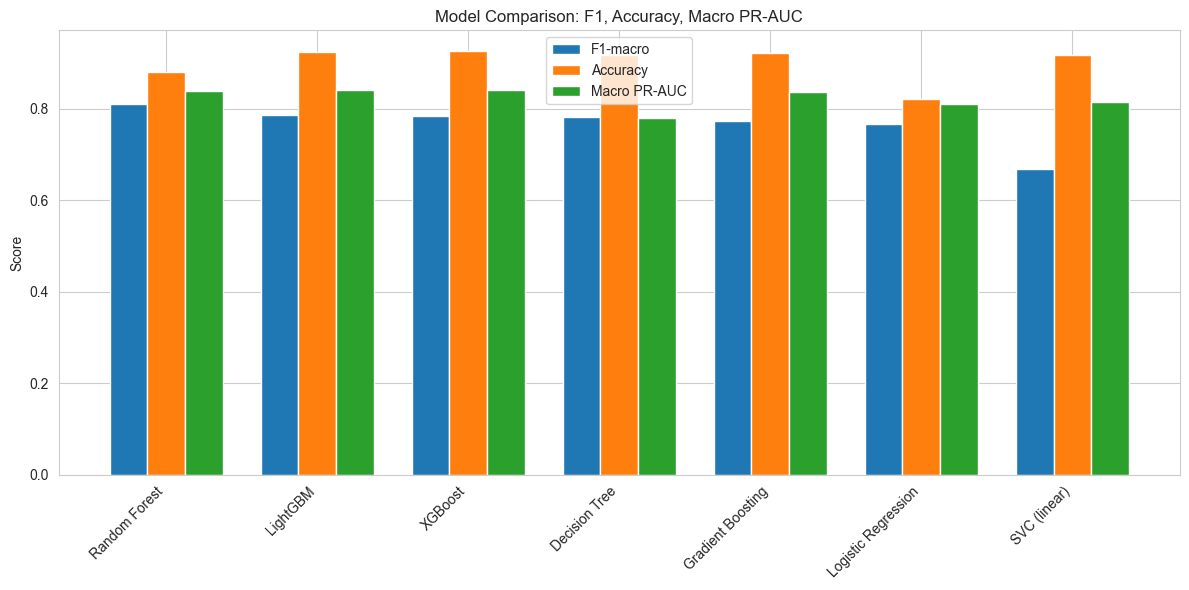


Best Model by F1: Random Forest


In [ ]:
# Cell 5 — Evaluate (NOW WITH PR-AUC + Final Comparison Plot)

from sklearn.metrics import precision_recall_curve, auc, average_precision_score

results = []

print("\n=== EVALUATION ON TEST SET (with PR-AUC) ===")

for name, model in best_models.items():
    print("\n" + "-" * 80)
    print(f"MODEL: {name}")

    # -------------------------
    # Predictions
    # -------------------------
    y_pred = model.predict(X_test)

    # Need probability scores for PR-AUC
    try:
        y_proba = model.predict_proba(X_test)
    except:
        print("Model has no predict_proba — using decision_function")
        y_proba = model.decision_function(X_test)

    # -------------------------
    # F1 + Accuracy
    # -------------------------
    f1 = f1_score(y_test, y_pred, average="macro")
    acc = accuracy_score(y_test, y_pred)

    # -------------------------
    # *** PR-AUC ***
    # -------------------------
    macro_pr_auc = average_precision_score(y_test, y_proba, average="macro")

    per_class_pr_auc = {}
    for i, cls in enumerate(le.classes_):
        per_class_pr_auc[cls] = average_precision_score(
            (y_test == i).astype(int), y_proba[:, i]
        )

    # Store results
    results.append([name, f1, acc, macro_pr_auc, per_class_pr_auc])

    print(f"Test F1: {f1:.4f} | Accuracy: {acc:.4f}")
    print(f"Macro PR-AUC: {macro_pr_auc:.4f}")

    print("\nPer-class PR-AUC:")
    for cls, ap in per_class_pr_auc.items():
        print(f"  {cls}: {ap:.4f}")

    # -------------------------
    # Classification report
    # -------------------------
    print("\nClassification Report")
    print(classification_report(y_test, y_pred, target_names=le.classes_))

    # -------------------------
    # Confusion Matrix
    # -------------------------
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=le.classes_,
        yticklabels=le.classes_,
    )
    plt.title(f"Confusion Matrix — {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # -------------------------
    # Precision–Recall Curves
    # -------------------------
    plt.figure(figsize=(7, 6))
    for i, cls in enumerate(le.classes_):
        precision, recall, _ = precision_recall_curve(
            (y_test == i).astype(int), y_proba[:, i]
        )
        plt.plot(recall, precision, label=f"{cls} (PR-AUC={per_class_pr_auc[cls]:.3f})")

    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.title(f"Precision-Recall Curve — {name}")
    plt.legend()
    plt.grid(True)
    plt.show()


# -----------------------------
# Convert to DataFrame
# -----------------------------
results_df = pd.DataFrame(
    results, columns=["Model", "F1", "Accuracy", "Macro PR-AUC", "Per-Class PR-AUC"]
).sort_values("F1", ascending=False)

display(results_df)


# ==========================================================
# PLOT: Best model comparison across all metrics
# ==========================================================

plt.figure(figsize=(12, 6))
bar_width = 0.25

indices = np.arange(len(results_df))

plt.bar(indices, results_df["F1"], width=bar_width, label="F1-macro")
plt.bar(indices + bar_width, results_df["Accuracy"], width=bar_width, label="Accuracy")
plt.bar(
    indices + 2 * bar_width,
    results_df["Macro PR-AUC"],
    width=bar_width,
    label="Macro PR-AUC",
)

plt.xticks(indices + bar_width, results_df["Model"], rotation=45, ha="right")
plt.ylabel("Score")
plt.title("Model Comparison: F1, Accuracy, Macro PR-AUC")
plt.legend()
plt.tight_layout()
plt.show()

print("\nBest Model by F1:", results_df.iloc[0]["Model"])

In [ ]:
# Cell 6 — Ensemble
top4 = results_df["Model"].head(4).tolist()
print("Top 4 models:", top4)

estimators = [(m.replace(" ", "_"), best_models[m]) for m in top4]

# Soft voting
voting = VotingClassifier(estimators=estimators, voting="hard")
voting.fit(X_train, y_train)
y_pred = voting.predict(X_test)

print("\nVoting F1:", f1_score(y_test, y_pred, average="macro"))

# Stacking
stack = StackingClassifier(
    estimators=estimators, final_estimator=LogisticRegression(max_iter=3000)
)
stack.fit(X_train, y_train)

y_pred = stack.predict(X_test)
print("\nStacking F1:", f1_score(y_test, y_pred, average="macro"))

In [ ]:
# Cell 7 — Final selection
final_candidates = results_df.copy()

final_candidates.loc[len(final_candidates)] = [
    "VotingClassifier",
    f1_score(y_test, voting.predict(X_test), average="macro"),
    None,
]

final_candidates.loc[len(final_candidates)] = [
    "StackingClassifier",
    f1_score(y_test, stack.predict(X_test), average="macro"),
    None,
]

final_candidates = final_candidates.sort_values("F1", ascending=False)
display(final_candidates)

best_name = final_candidates.iloc[0]["Model"]
print("Best model:", best_name)

final_model = (
    voting
    if best_name == "VotingClassifier"
    else stack if best_name == "StackingClassifier" else best_models[best_name]
)

joblib.dump(final_model, os.path.join(MODELS_DIR, "best_classifier_final.joblib"))
print("Saved final best model.")